# DIP Assignment 3

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from numpy import linalg as LA
import math
import os
from collections import defaultdict
import scipy.fftpack as fp
from numpy.fft import fft2, ifft2
from skimage import color, data, restoration
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from itertools import cycle
from PIL import Image
from sklearn import decomposition

ModuleNotFoundError: No module named 'cv2'

In [7]:
import cv2
img = cv2.imread('cat.jpg') 
plt.imshow(img[:,:,0],cmap='gray')
plt.title('Subject Image')

ModuleNotFoundError: No module named 'cv2'

In [15]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = 100**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="unif":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

c:\users\manvendra\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\users\manvendra\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


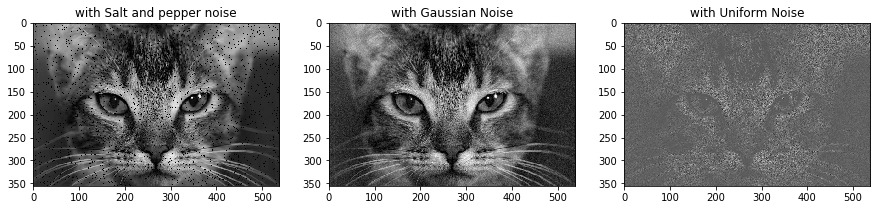

In [16]:
figure=plt.figure(figsize=(15,15))
#Adding salt and pepper noise in image
plt.subplot(1,3,1)
img1 = noisy("s&p",img[:,:,0])
img11=img1
plt.title('with Salt and pepper noise')
plt.imshow(img1,cmap='gray')

x=img[:,:,0]
noisy_img = x + np.random.normal(0, 10, x.shape)
img2 = np.clip(noisy_img, 0, 255)
img22=img2
plt.subplot(1,3,2)
plt.title('with Gaussian Noise')
plt.imshow(img2,cmap='gray')

#Adding Uniform noise in image
img3=noisy("unif",img[:,:,0])
img33=img3
plt.subplot(1,3,3)
plt.title('with Uniform Noise')
plt.imshow(img3,cmap='gray')

# ----Salt and pepper noise----

# Denoising with Low pass filter

216 328
(216, 328)
(216, 328)


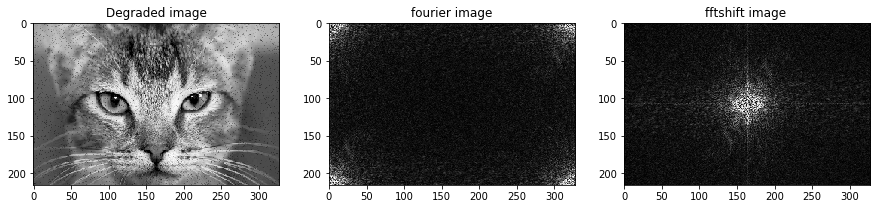

In [17]:
#Calculating FFT then shifting it to origin of image and then finally calculating the absolute value
img1 = cv2.imread('cat1.png',0) 
figure=plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((img1),cmap='Greys_r')
plt.title('Degraded image')
rows=img1.shape[0]
cols=img1.shape[1]
if (rows%2==0 and cols%2!=0):
    img1=np.concatenate((img1,np.zeros((1,cols))),axis=0)
if (rows%2!=0 and cols%2==0):
    img1=np.concatenate((img1,np.zeros((rows,1))),axis=1)
if (rows%2!=0 and cols%2!=0):
    img1=np.concatenate((img1,np.zeros((1,cols))),axis=0)
    img1=np.concatenate((img1,np.zeros((rows+1,1))),axis=1)
[rows,cols]=img1.shape
img1 = cv2.normalize(img1.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
img1=np.double(img1)
A=np.fft.fft2(img1)
plt.subplot(1,3,2)
plt.imshow(np.uint8(abs(A)),cmap='Greys_r')
plt.title('fourier image')
A1=np.fft.fftshift(A)
Abs=abs(A1)
plt.subplot(1,3,3)
plt.imshow(np.uint8(Abs),cmap='Greys_r')
plt.title('fftshift image ')
print(rows,cols)
print(A1.shape)
print(Abs.shape)

In [ ]:
horz=int(input('Enter horizontal cutoff= '))
vert=int(input('Enter vertical cutoff= '))

#-----------------------------------------------for Low pass filter----------------------------------------------- 
w=(rows-2*horz)/2
x=(cols-2*vert)/2
temp1=np.zeros((int(w),int(cols)))
temp2=np.zeros((2*horz,int(x)))
d1=np.concatenate((temp2, np.ones((2*horz, 2*vert)), temp2), axis=1)
d2=np.concatenate((temp1,d1,temp1), axis=0)
print(d2.shape)
#computing the FFT of Low pass image
finalfft=np.multiply(d2,(A1))
#Inverse FFT step
figure=plt.figure(figsize=(15,15))
B=np.fft.fftshift(finalfft)
B1=np.fft.ifft2(B)
B2=abs(B1)
print(B2.shape)
plt.subplot(1,2,1),plt.imshow(np.uint8(abs(finalfft)),cmap='Greys_r')
plt.title('filter in fourier')
plt.subplot(1,2,2),plt.imshow(B2,cmap='Greys_r')
plt.title('Image after passing through low pass filter')

# Denoising with Inverse Filter  

In [ ]:
# img1 = cv2.imread('cat1.png',0)
# create the motion blur kernel
size = 17
kernel = np.zeros((size, size))
kernel[int((size-1)/2), :] = np.ones(size)
kernel = kernel / size
kernel = np.pad(kernel, (((img1.shape[0]-size)//2,(img1.shape[0]-size)//2+1), ((img1.shape[1]-size)//2,(img1.shape[1]-size)//2+1)))
 
freq = fp.fft2(img1)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved1 = freq*freq_kernel
im_blur = fp.ifft2(convolved1).real
im_blur = im_blur / np.max(im_blur)
 
epsilon = 10**-6
 
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel)
 
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = im_restored / np.max(im_restored)
 
plt.figure(figsize=(18,12))
plt.subplot(131)
plt.imshow(im, cmap='gray')
plt.title('Degraded image')
plt.axis('off')
plt.subplot(132)
plt.imshow(im_blur, cmap='gray')
plt.title('Blurred image with motion blur kernel')
plt.axis('off')
plt.subplot(133)
plt.imshow(im_restored, cmap='gray')
plt.title('Restored image with inverse filter')
plt.axis('off')
plt.show()

# Denoising with Weiner filter

In [ ]:
def wiener_filter(img, kernel, K ):
    dummy = np.copy(img)
    kernel = np.pad(kernel, [(0, dummy.shape[0] - kernel.shape[0]), (0, dummy.shape[1] - kernel.shape[1])], 'constant')
    # Fourier Transform
    dummy = fft2(dummy)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return np.uint8(dummy)

In [ ]:
k=int(input('Enter the value of k(noise to signal ratio)= '))
psf = np.ones((5,5)) / 5**2
x=wiener_filter(img11,psf,k)
plt.imshow(x,cmap='gray')
plt.title('Restored Image by wiener filter')

# Denoising Image by Bilateral filter

In [ ]:
sigmaR=int(input('Enter the value of SigmaR= '))
sigmaP=int(input('Enter the value of SigmaP= '))
bilateral = cv2.bilateralFilter(im, 15, sigmaR, sigmaP)   
plt.imshow(bilateral,cmap='gray')
plt.title('Restored image by bilateral filter')

# ----Gaussian Noise----

In [ ]:
plt.imshow(img2,cmap='gray')
plt.title('Distorted image')

# Denoising with Low pass filter

In [ ]:
figure=plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((img2),cmap='Greys_r')
plt.title('Degraded image')
rows=img2.shape[0]
cols=img2.shape[1]
if (rows%2==0 and cols%2!=0):
    img2=np.concatenate((img2,np.zeros((1,cols))),axis=0)
if (rows%2!=0 and cols%2==0):
    img2=np.concatenate((img2,np.zeros((rows,1))),axis=1)
if (rows%2!=0 and cols%2!=0):
    img2=np.concatenate((img2,np.zeros((1,cols))),axis=0)
    img2=np.concatenate((img2,np.zeros((rows+1,1))),axis=1)
[rows,cols]=img2.shape
img2 = cv2.normalize(img2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
img2=np.double(img2)
A=np.fft.fft2(img2)
plt.subplot(1,3,2)
plt.imshow(np.uint8(abs(A)),cmap='Greys_r')
plt.title('fourier image')
A2=np.fft.fftshift(A)
Abs=abs(A2)
plt.subplot(1,3,3)
plt.imshow(np.uint8(Abs),cmap='Greys_r')
plt.title('fftshift image ')
print(rows,cols)
print(A2.shape)
print(Abs.shape)

In [ ]:
horz=int(input('Enter horizontal cutoff= '))
vert=int(input('Enter vertical cutoff= '))

#-----------------------------------------------for Low pass filter----------------------------------------------- 
w=(rows-2*horz)/2
x=(cols-2*vert)/2
temp1=np.zeros((int(w),int(cols)))
temp2=np.zeros((2*horz,int(x)))
d1=np.concatenate((temp2, np.ones((2*horz, 2*vert)), temp2), axis=1)
d2=np.concatenate((temp1,d1,temp1), axis=0)
print(d2.shape)
#computing the FFT of Low pass image
finalfft=np.multiply(d2,(A2))
#Inverse FFT step
figure=plt.figure(figsize=(15,15))
B=np.fft.fftshift(finalfft)
B1=np.fft.ifft2(B)
B2=abs(B1)
print(B2.shape)
plt.subplot(1,2,1),plt.imshow(np.uint8(abs(finalfft)),cmap='Greys_r')
plt.title('filter in fourier')
plt.subplot(1,2,2),plt.imshow(B2,cmap='Greys_r')
plt.title('Image after passing through low pass filter')

# Denoising with Inverse filter

In [ ]:
# create the motion blur kernel
size = 21
kernel = np.zeros((size, size))
kernel[int((size-1)/2), :] = np.ones(size)
kernel = kernel / size
kernel = np.pad(kernel, (((img2.shape[0]-size)//2,(img2.shape[0]-size)//2+1), ((img2.shape[1]-size)//2,(img2.shape[1]-size)//2+1)))
 
freq = fp.fft2(img2)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved1 = freq*freq_kernel
im_blur = fp.ifft2(convolved1).real
im_blur = im_blur / np.max(im_blur)
 
epsilon = 10**-20
 
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel)
 
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = im_restored / np.max(im_restored)
 
plt.figure(figsize=(18,12))
plt.subplot(131)
plt.imshow(img2, cmap='gray')
plt.title('Degraded image')
plt.axis('off')
plt.subplot(132)
plt.imshow(im_blur, cmap='gray')
plt.title('Blurred image with motion blur kernel')
plt.axis('off')
plt.subplot(133)
plt.imshow(im_restored, cmap='gray')
plt.title('Restored image with inverse filter')
plt.axis('off')
# plt.subplot(224)
# plt.imshow(im_restored - im, cmap='gray')
# plt.title('Diff restored &amp;amp;amp;amp;amp;amp; original image', size=20)
# plt.axis('off')
plt.show()

# Denoising with Weiner filter

In [ ]:
k=int(input('Enter the value of k(signal to noise ratio)= '))
psf = np.ones((5,5)) / 5**2
x=wiener_filter(img22,psf,k)
plt.imshow(x,cmap='gray')
plt.title('Restored Image by wiener filter')

# Denoising with Bilateral filter

In [ ]:
sigmaR=int(input('Enter the value of SigmaR= '))
sigmaP=int(input('Enter the value of SigmaP= '))
x=np.uint8(img22)
bilateral = cv2.bilateralFilter(x, 15, sigmaR, sigmaP)   
plt.imshow(bilateral,cmap='gray')
plt.title('Restored image by bilateral filter')

# ----Uniform Noise----

In [ ]:
plt.imshow(img3,cmap='gray')
plt.title('Distorted image')

# Denoising with Low pass filter 

In [ ]:
# img3=img3[:,:,0]
figure=plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((img3),cmap='Greys_r')
plt.title('Degraded image')
rows=img3.shape[0]
cols=img3.shape[1]
if (rows%2==0 and cols%2!=0):
    img3=np.concatenate((img3,np.zeros((1,cols))),axis=0)
if (rows%2!=0 and cols%2==0):
    img3=np.concatenate((img3,np.zeros((rows,1))),axis=1)
if (rows%2!=0 and cols%2!=0):
    img3=np.concatenate((img3,np.zeros((1,cols))),axis=0)
    img3=np.concatenate((img3,np.zeros((rows+1,1))),axis=1)
[rows,cols]=img3.shape
img3 = cv2.normalize(img3.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
img3=np.double(img3)
A=np.fft.fft2(img3)
plt.subplot(1,3,2)
plt.imshow(np.uint8(abs(A)),cmap='Greys_r')
plt.title('fourier image')
A2=np.fft.fftshift(A)
Abs=abs(A2)
plt.subplot(1,3,3)
plt.imshow(np.uint8(Abs),cmap='Greys_r')
plt.title('fftshift image ')
print(rows,cols)
print(A2.shape)
print(Abs.shape)

In [ ]:
horz=int(input('Enter horizontal cutoff= '))
vert=int(input('Enter vertical cutoff= '))

#-----------------------------------------------for Low pass filter----------------------------------------------- 
w=(rows-2*horz)/2
x=(cols-2*vert)/2
temp1=np.zeros((int(w),int(cols)))
temp2=np.zeros((2*horz,int(x)))
d1=np.concatenate((temp2, np.ones((2*horz, 2*vert)), temp2), axis=1)
d2=np.concatenate((temp1,d1,temp1), axis=0)
print(d2.shape)
#computing the FFT of Low pass image
finalfft=np.multiply(d2,(A2))
#Inverse FFT step
figure=plt.figure(figsize=(15,15))
B=np.fft.fftshift(finalfft)
B1=np.fft.ifft2(B)
B2=abs(B1)
print(B2.shape)
plt.subplot(1,2,1),plt.imshow(np.uint8(abs(finalfft)),cmap='Greys_r')
plt.title('filter in fourier')
plt.subplot(1,2,2),plt.imshow(B2,cmap='Greys_r')
plt.title('Image after passing through low pass filter')

# Denoisng with Inverse filter

In [ ]:
# create the motion blur kernel
size = 21
kernel = np.zeros((size, size))
kernel[int((size-1)/2), :] = np.ones(size)
kernel = kernel / size
kernel = np.pad(kernel, (((img3.shape[0]-size)//2,(img3.shape[0]-size)//2+1), ((img3.shape[1]-size)//2,(img3.shape[1]-size)//2+1)))
 
freq = fp.fft2(img3)
freq_kernel = fp.fft2(fp.ifftshift(kernel))
convolved1 = freq*freq_kernel
im_blur = fp.ifft2(convolved1).real
im_blur = im_blur / np.max(im_blur)
 
epsilon = 10**-20
 
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel)
 
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = im_restored / np.max(im_restored)
 
plt.figure(figsize=(18,12))
plt.subplot(131)
plt.imshow(img3, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(132)
plt.imshow(im_blur, cmap='gray')
plt.title('Blurred image with motion blur kernel')
plt.axis('off')
plt.subplot(133)
plt.imshow(im_restored, cmap='gray')
plt.title('Restored image with inverse filter')
plt.axis('off')
# plt.subplot(224)
# plt.imshow(im_restored - im, cmap='gray')
# plt.title('Diff restored &amp;amp;amp;amp;amp;amp; original image', size=20)
# plt.axis('off')
plt.show()

# Denoising Wiener filter

In [ ]:
k=int(input('Enter the value of k(signal to noise ratio)= '))
psf = np.ones((5,5)) / 5**2
x=wiener_filter(img33,psf,k)
plt.imshow(x,cmap='gray')
plt.title('Restored Image by wiener filter')

# Denoising with Bilateral Filter

In [ ]:
sigmaR=int(input('Enter the value of SigmaR= '))
sigmaP=int(input('Enter the value of SigmaP= '))
x=np.uint8(img33)
bilateral = cv2.bilateralFilter(x, 15, sigmaR, sigmaP)   
plt.imshow(bilateral,cmap='gray')
plt.title('Restored image by Bilateral filter')

# ----Question 2----

# ----K-Mean----

In [ ]:
def k_mean(data,k):
    iters=0
    q=1
    r_mean=data.sample(k)
    while q>0:
        ind=r_mean.index.tolist()
        indx=data.index.tolist()
        col=data.columns.tolist()
        dist=pd.DataFrame()
        for i in range (k):
            distance=(data[col] - np.array(r_mean.loc[ind[i]])).pow(2).sum(1).pow(0.5)
            v=i+1
            v=str(v)          
            dist['d'+v]=distance
        col_dist=dist.columns.tolist()
        #--------------------------------------------------------------------------------------------------
        var=pd.DataFrame(dist.idxmin(axis=1),columns=['class'])
        u_mean=[]
        col.append('class')
        new_data=pd.DataFrame(columns=col)
        for i in range(k):
            index1=(var[var['class']==col_dist[i]]).index.tolist()
            cluster=data.loc[data.index.isin(index1)]
            m=cluster.mean().tolist()
            u_mean.append(m)
            l=len(cluster)
            list1=[]
            for j in range (l):
                list1.append(i+1)
            cluster['class']=list1
            new_data=new_data.append(cluster)
        col.remove(col[-1])
        u_mean=pd.DataFrame(u_mean,columns=col,index=ind)
        if u_mean.equals(r_mean):
            q=0
        else:
            r_mean=u_mean    
                
        res=new_data.reindex(indx)
        iters=iters+1
        label=res['class'].tolist()
        temp1=set(label)
        temp1=list(temp1)
        var3=0
        for i in range (k):
            for j in range (len(label)):
                var2=label[j]
                if var2==temp1[i]:
                    label[j]=var3
            var3=var3+1
    return new_data,u_mean,res,iters,label


In [ ]:
original_image=cv2.imread('cat.jpg',1)

img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
print(vectorized)

In [ ]:
data=pd.DataFrame(vectorized,columns=['R','G','B'])
print(data)
k=2

In [ ]:
[x,y,z,a,b]=k_mean(data,k)

In [ ]:
m=y.index.tolist()
n=x.index.tolist()
o=z.index.tolist()


list_=[]
for i in range (len(m)):
    h1=(y.loc[m[i]]).tolist()
    h2=x[x['class']==i+1]
    l1=len(h2)
    for j in range (l1):
        list_.append(h1)
        
    
res1=pd.DataFrame(list_,columns=['R','G','B'],index=n)
res1=res1.reindex(o)
list_1=[]
for g in range (len(res1)):
    h3=(res1.loc[g]).tolist()
    list_1.append(h3)
listx=np.array(list_1)    
listx=np.uint8(listx)
result_image = listx.reshape((img.shape))
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image,cmap='gray')
h5=str(k)
plt.title('image for k='+h5), plt.xticks([]), plt.yticks([])
plt.show()

# ----OTSU Segmentation----

In [ ]:
img=cv2.imread('C.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
[m,n]=img.shape
hist=hist/(m*n)
x=np.arange(0,256)
figure=plt.plot(figsize=(20,20))
plt.scatter(x,hist)
plt.title('histogram')
plt.xlabel('gray level')
plt.ylabel('normlised frequencies')
plt.grid(True)

In [ ]:
hist=list(hist)
k=1
list1=[]
for i in range (k,255):
    w1=0
    w2=0
    u1=0
    u2=0
    sigma1=0
    sigma2=0
    for i in range (256):
        if i<=k:
            w1=w1+hist[i]
        else:
            w2=w2+hist[i]
    for i in range (256):
        if i<=k:
            var2=i*hist[i]
            u1=u1+var2
        else:
            var2=i*hist[i] 
            u2=u2+var2
    u1=u1/w1
    u2=u2/w2
    uT=w1*u1+w2*u2
    for i in range (256):
        if i<=k:
            var3=((i-u1)**2)*hist[i]
            sigma1=sigma1+var3
        else:
            var4=((i-u2)**2)*hist[i]
            sigma2=sigma2+var4
            
    sigma1=sigma1/w1
    sigma2=sigma2/w2
    sigmaT=sigma1+sigma2
    sigmaB=w1*((u1-uT)**2)+w2*((u2-uT)**2)
    list1.append(sigmaB)
    k=k+1    
x1=list1.index(max(list1)) 
threshold=x1+1
print(threshold)


In [ ]:
figure=plt.figure(figsize=(20,20))
plt.subplot(1,2,1),plt.imshow(img,cmap='gray')
plt.title('Original image')
img[img>=threshold]=255
img[img<threshold]=0
plt.subplot(1,2,2),plt.imshow(img,cmap='gray')
plt.title('Segmented image by OTSU method')
